Read and visualize exports from sailbuoy school detection at Polar Front

In [2]:
import glob
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import seaborn as sns
%matplotlib inline

In [3]:
plt.rcParams['font.size']= 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 12

## Load datasets

### Iskant 2022

In [983]:
# make a list of filenames
data_path = "E:/PolarFront-Exports/Iskant2022/Export_WeakStrong_schools/"
csv_file_names = sorted(glob.glob(data_path + '*-Phase0-D2022*.csv'))

# Combine files
Iskant_22 = pd.concat([pd.read_csv(f, skiprows=0) for f in csv_file_names], axis=0)

# Combine date and time column
Iskant_22['datetime'] = pd.to_datetime(Iskant_22['Date_M'].apply(str) + Iskant_22['Time_M'], format='%Y%m%d %H:%M:%S.%f')

Iskant_22['platform'] = 'Sailbuoy Iskant 2022'

In [984]:
# Example echograms time
start_echo = dt.datetime(2022,5,24)
mid_echo = dt.datetime(2022,6,5)
end_echo = dt.datetime(2022,7,8)

# Location data

In [8]:
SB_Iskant = pd.read_excel("E:/PolarFront2022/2022-05/sailbuoy/2022_polarfront_sb_iskant/datalogger/DATA_SBIskant2022_PF.xlsx", header=0, usecols=['Time','Lat','Long'])

In [9]:
SB_Iskant['Time'] = pd.to_datetime(SB_Iskant.Time)
SB_Iskant22_times = SB_Iskant.set_index(['Time']).resample('1min').interpolate()

# Combine location + data

In [987]:
index = []

#select iskant 22
isk_22 = Iskant_22[Iskant_22['platform']=='Sailbuoy Iskant 2022'].reset_index()
for ind in range(len(isk_22)):
    ind_index = SB_Iskant22_times.index.get_loc(isk_22.datetime[ind], method="nearest")
    index = np.append(index, ind_index)
    
#Reset index
SB_Iskant22_times = SB_Iskant22_times.reset_index()

# New df with GPS+Sv data
Isk_22_df = pd.DataFrame()
long = SB_Iskant22_times['Long'][index]
lat = SB_Iskant22_times['Lat'][index]
Isk_22_df['Time'] = isk_22.datetime
Isk_22_df['Long'] = np.array(long)
Isk_22_df['Lat'] = np.array(lat)
Isk_22_df['Sv_mean'] = isk_22.Sv_mean
Isk_22_df['Region_class'] = isk_22.Region_class
Isk_22_df['NASC'] = isk_22.NASC

In [1112]:
Isk_daily =Isk_22_df.set_index('Time').resample('1D').mean()

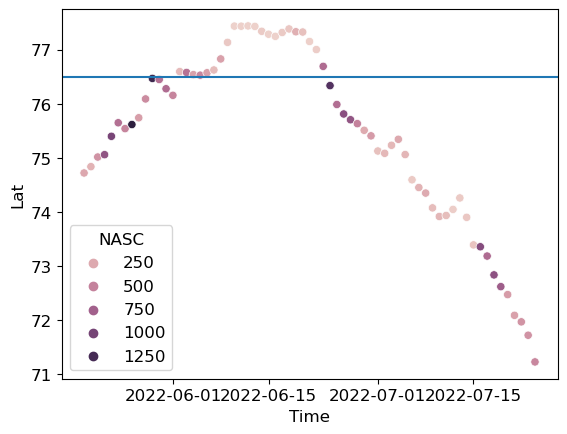

In [1120]:
sns.scatterplot(data=Isk_daily, x='Time',y='Lat', hue='NASC')
plt.axhline(y=76.5)

In [988]:
Isk_22_df['Region_class'].unique()

array(['SSL Strong', 'SSL weak'], dtype=object)

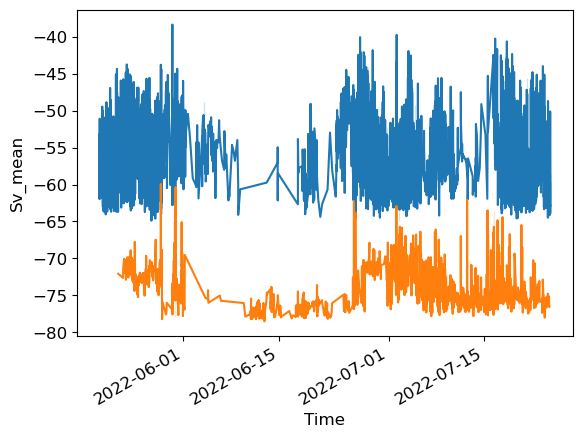

In [989]:
strong = Isk_22_df[Isk_22_df['Region_class']=='SSL Strong']
weak = Isk_22_df[Isk_22_df['Region_class']=='SSL weak']

sns.lineplot(data=strong, x='Time', y='Sv_mean')
sns.lineplot(data=weak, x='Time', y='Sv_mean')
#sns.lineplot(data=Iskant_21, x='datetime', y='Sv_mean', hue='Layer_depth_min')
plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(date_form)

In [990]:
strong_count = strong.set_index('Time').resample('1D').count()
weak_count = weak.set_index('Time').resample('1D').count()

In [991]:
strong_mean = strong.set_index('Time').resample('1D').mean()
weak_mean = weak.set_index('Time').resample('1D').mean()

Text(0.5, 0, 'Latitude')

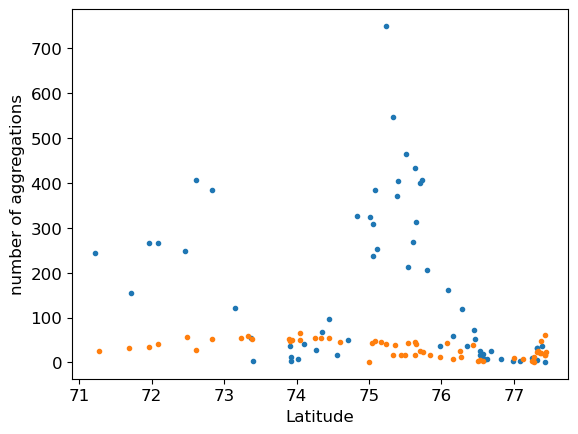

In [992]:
plt.plot(strong_mean['Lat'],strong_count['Region_class'], '.')
plt.plot(weak_mean['Lat'],weak_count['Region_class'], '.')
plt.ylabel('number of aggregations')
plt.xlabel('Latitude')

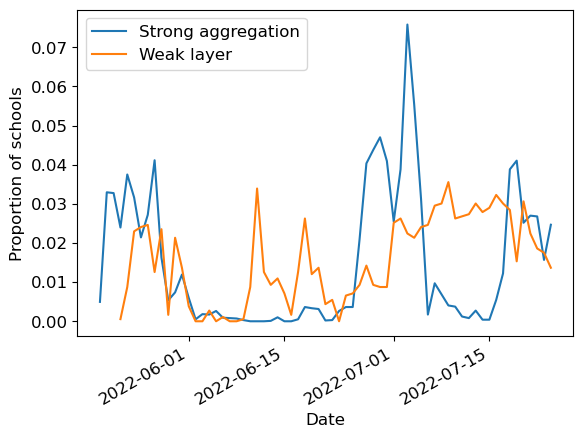

In [993]:
ax = plt.subplot()
plt.plot(strong_count.index,strong_count['Region_class']/np.sum(strong_count['Region_class']), label='Strong aggregation')
plt.plot(weak_count.index, weak_count['Region_class']/np.sum(weak_count['Region_class']), label='Weak layer')
plt.gcf().autofmt_xdate()
plt.ylabel('Proportion of schools')
plt.xlabel('Date')
plt.legend()

In [994]:
iskant_daily = Iskant_22.set_index('datetime').groupby('Region_class').resample('1D').mean()
nRegions = Iskant_22.set_index('datetime').groupby('Region_class').resample('1D').count()['Region_class']
nRegions = nRegions.reset_index('datetime')
iskant_daily['nRegions']=nRegions['Region_class'][:].values
iskant_daily = iskant_daily.reset_index()

In [995]:
iskant_daily

,Region_class,datetime,Region_ID,Process_ID,Sv_mean,NASC,Sv_max,Sv_min,Sv_noise,NASC_noise,...,Region_bottom_altitude_mean,Region_top_altitude_min,Region_top_altitude_max,Region_top_altitude_mean,Center_of_mass,Inertia,Proportion_occupied,Equivalent_area,Aggregation_index,nRegions
0,SSL Strong,2022-05-19,25.000000,2886.000000,-58.054233,262.103702,-48.764457,-86.084716,-960.342590,0.0,...,26.073035,27.267347,30.324490,29.000443,52.380882,1.940539,0.992451,30.727326,0.065814,49
1,SSL Strong,2022-05-20,50.914110,2888.254601,-58.810139,192.923653,-49.631900,-86.815322,-961.449412,0.0,...,30.650633,31.576994,34.866886,33.497340,47.857356,3.487188,0.992903,77.213622,0.069997,326
2,SSL Strong,2022-05-21,53.253086,2891.206790,-58.188493,400.136630,-47.869270,-91.794838,-960.117165,0.0,...,25.345009,27.466667,32.087963,30.121916,51.937490,7.528844,0.980583,163.978037,0.082798,324
3,SSL Strong,2022-05-22,44.611814,2894.430380,-55.396495,855.555841,-44.326912,-94.721035,-962.586406,0.0,...,31.264656,33.568354,38.481013,36.342133,45.845526,6.486106,0.974810,146.686026,0.102775,237
4,SSL Strong,2022-05-23,58.382749,2897.463612,-54.278778,1031.639328,-43.185207,-93.429303,-965.285065,0.0,...,41.402129,43.148518,46.684097,45.178406,36.446629,3.601987,0.981469,61.019842,0.112666,371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,SSL weak,2022-07-20,93.642857,3082.892857,-74.649822,12.713922,-57.917181,-108.943277,-961.974154,0.0,...,29.410667,35.275000,46.482186,41.552771,44.214487,31.035576,0.989955,536.358040,0.008724,56
127,SSL weak,2022-07-21,89.951220,3086.317073,-76.096624,10.457013,-60.578339,-105.501117,-965.201746,0.0,...,39.674859,48.421951,55.480488,52.338308,33.598131,22.435019,0.998258,1140.759485,0.014939,41
128,SSL weak,2022-07-22,101.000000,3089.323529,-74.972768,15.777711,-57.122761,-107.635439,-966.249851,0.0,...,40.782287,48.873529,57.844118,54.172686,32.022340,27.437370,0.994767,871.379160,0.015061,34
129,SSL weak,2022-07-23,60.031250,3093.125000,-75.554925,13.341803,-60.205504,-110.074378,-961.705464,0.0,...,27.773853,34.796875,47.150000,42.242310,44.341437,38.187003,0.987776,1049.778695,0.003174,32


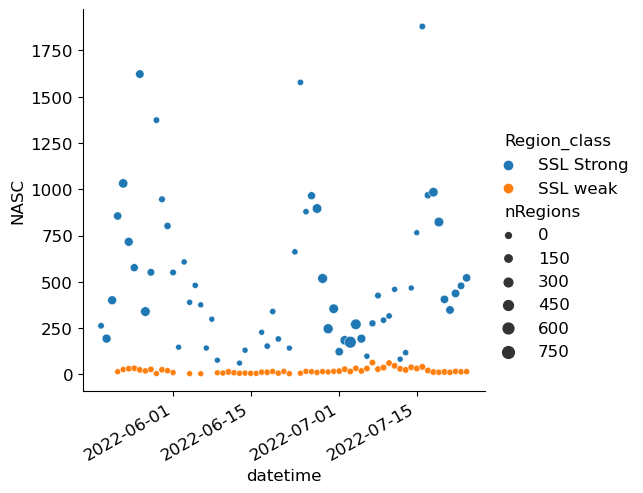

In [996]:
sns.relplot(data=iskant_daily, x='datetime', y='NASC', hue='Region_class', size='nRegions')
plt.gcf().autofmt_xdate()


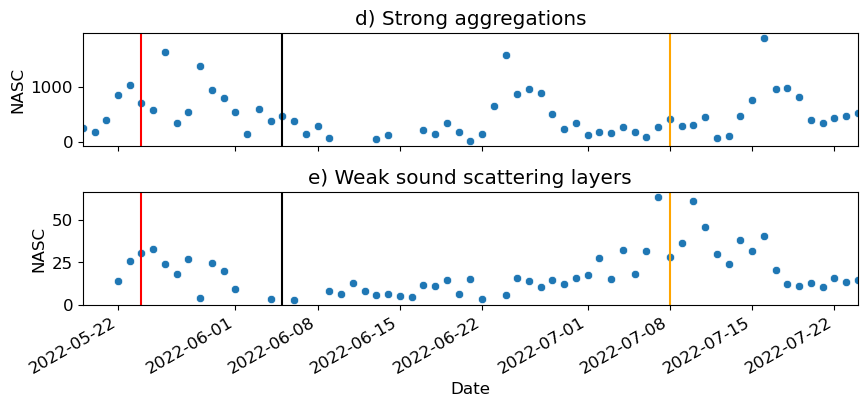

In [1076]:
fig, ax = plt.subplots(2,1, figsize=(10,4))
axes = ax.flatten()
fig.subplots_adjust(hspace=.4, wspace=0.4)
#sns.lineplot(ax = axes[0], data=iskant_daily, x='datetime', y='Sv_mean',hue='Region_class')
strong_agg = iskant_daily[iskant_daily['Region_class']=='SSL Strong'].reset_index()
s = sns.scatterplot(ax = axes[0], data=strong_agg, x='datetime', y='NASC', palette='Blues')
weak_layer = iskant_daily[iskant_daily['Region_class']=='SSL weak'].reset_index()
w = sns.scatterplot(ax = axes[1], data=weak_layer, x='datetime', y='NASC', palette='Greens')

plt.gcf().autofmt_xdate()
axes[0].set_xlim([dt.datetime(2022,5,19),dt.datetime(2022,7,24)])
axes[1].set_xlim([dt.datetime(2022,5,19),dt.datetime(2022,7,24)])

axes[0].set_title('d) Strong aggregations')
axes[1].set_title('e) Weak sound scattering layers')
#axes[0].set_ylabel('Aggregation index')
#axes[1].set_ylabel('Aggregation index')
axes[1].set_xlabel('Date')


axes[0].axvline(x = start_echo, color = 'r', label = 'a')
axes[0].axvline(x = mid_echo, color = 'k', label = 'b')
axes[0].axvline(x = end_echo, color = 'orange', label = 'c')
axes[1].axvline(x = start_echo, color = 'r', label = 'a')
axes[1].axvline(x = mid_echo, color = 'k', label = 'b')
axes[1].axvline(x = end_echo, color = 'orange', label = 'c')

In [998]:
# Plot example echogram
a_ex_sv_date = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsa.sv.csv', skiprows=1, header=None, usecols=[3,4])
a_Time = pd.to_datetime(a_ex_sv_date[3].apply(str) + a_ex_sv_date[4], format='%Y-%m-%d%H:%M:%S')

# Plot example echogram
b_ex_sv_date = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsb.sv.csv', skiprows=1, header=None, usecols=[3,4])
b_Time = pd.to_datetime(b_ex_sv_date[3].apply(str) + b_ex_sv_date[4], format='%Y-%m-%d%H:%M:%S')

# Plot example echogram
c_ex_sv_date = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsc.sv.csv', skiprows=1, header=None, usecols=[3,4])
c_Time = pd.to_datetime(c_ex_sv_date[3].apply(str) + c_ex_sv_date[4], format='%Y-%m-%d%H:%M:%S')

In [1073]:
a_ex_sv = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsa.sv.csv', skiprows=1, header=None, usecols=np.arange(13,400))
a_ex_sv[a_ex_sv<-999] = np.nan
b_ex_sv = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsb.sv.csv', skiprows=1, header=None, usecols=np.arange(13,400))
b_ex_sv[b_ex_sv<-999] = np.nan
c_ex_sv = pd.read_csv('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/SB_Fig/sv_3panelsc.sv.csv', skiprows=1, header=None, usecols=np.arange(13,400))
c_ex_sv[c_ex_sv<-999] = np.nan
depth = np.linspace(0,80,np.shape(a_ex_sv)[1])

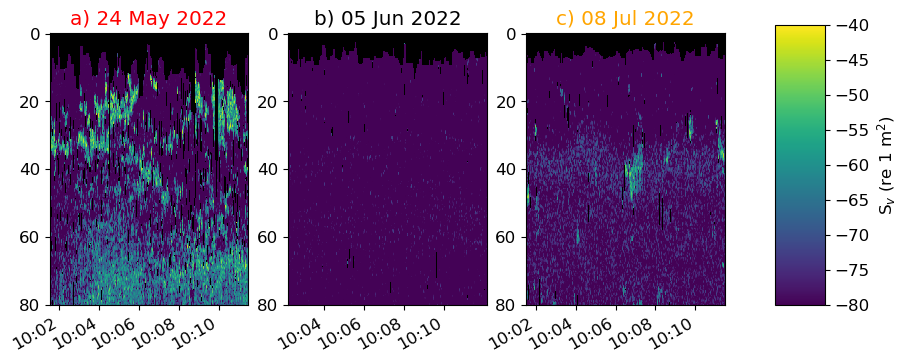

In [1091]:

minlocator = mdates.MinuteLocator(byminute=[2,4,6,8,10]) 
minlocator1 = mdates.MinuteLocator(byminute=[2,4,6,8,10]) 
minlocator2 = mdates.MinuteLocator(byminute=[2,4,6,8,10]) 
xfmt = mdates.DateFormatter('%H:%M')
cmap = mpl.cm.get_cmap("viridis").copy()

fig, ax = plt.subplots(1,3, figsize=(10,4))
axes = ax.flatten()
c=axes[0].pcolormesh(a_Time, depth, a_ex_sv.T, vmin=cmin,vmax=cmax, cmap=cmap)
c.cmap.set_over(cmap(-1))
c.cmap.set_under(cmap(1))
c.cmap.set_bad('k')
axes[0].xaxis.set_major_locator(minlocator)
axes[0].xaxis.set_major_formatter(xfmt)
axes[0].set_title(start_echo.strftime('a) %d %b %Y'), c='r')
axes[0].invert_yaxis()
axes[0].xaxis.set_major_formatter(xfmt)

c=axes[1].pcolormesh(b_Time, depth, b_ex_sv.T,vmin=cmin, vmax=cmax, cmap=cmap)
c.cmap.set_over(cmap(-1))
c.cmap.set_under(cmap(1))
c.cmap.set_bad('k')
axes[1].set_title(mid_echo.strftime('b) %d %b %Y'))
axes[1].invert_yaxis()
axes[1].xaxis.set_major_locator(minlocator1)
axes[1].xaxis.set_major_formatter(xfmt)

c= axes[2].pcolormesh(c_Time, depth, c_ex_sv.T,vmin=cmin, vmax=cmax, cmap=cmap)
c.cmap.set_over(cmap(-1))
c.cmap.set_under(cmap(1))
c.cmap.set_bad('k')
axes[2].set_title(end_echo.strftime('c) %d %b %Y'),c='orange')
axes[2].invert_yaxis()
axes[2].xaxis.set_major_locator(minlocator2)
axes[2].xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.7])
fig.colorbar(c, cax=cbar_ax, label='S$_{v}$ (re 1 m${^2}$)')


### Iskant 2021

In [62]:
# make a list of filenames
data_path = "E:/PolarFront-Exports/Iskant2021/Export_WeakStrong_schools2021/"
csv_file_names = sorted(glob.glob(data_path + '*-D2021*.csv'))

# Combine files
Iskant_21 = pd.concat([pd.read_csv(f, skiprows=0) for f in csv_file_names[:-2]], axis=0)

# Combine date and time column
Iskant_21['datetime'] = pd.to_datetime(Iskant_21['Date_M'].apply(str) + Iskant_21['Time_M'], format='%Y%m%d %H:%M:%S.%f')
Iskant_21['platform'] = 'Sailbuoy Iskant 2021'

In [63]:
index = []

#select iskant 22
isk_21 = Iskant_21[Iskant_21['platform']=='Sailbuoy Iskant 2021'].reset_index()
for ind in range(len(isk_21)):
    ind_index = SB_Iskant22_times.index.get_loc(isk_21.datetime[ind], method="nearest")
    index = np.append(index, ind_index)
    
#Reset index
SB_Iskant21_times = SB_Iskant22_times.reset_index()

# New df with GPS+Sv data
Isk_21_df = pd.DataFrame()
long = SB_Iskant21_times['Long'][index]
lat = SB_Iskant21_times['Lat'][index]
Isk_21_df['Time'] = isk_21.datetime
Isk_21_df['Long'] = np.array(long)
Isk_21_df['Lat'] = np.array(lat)
Isk_21_df['Sv_mean'] = isk_21.Sv_mean
Isk_21_df['Region_class'] = isk_21.Region_class
Isk_21_df['NASC'] = isk_21.NASC

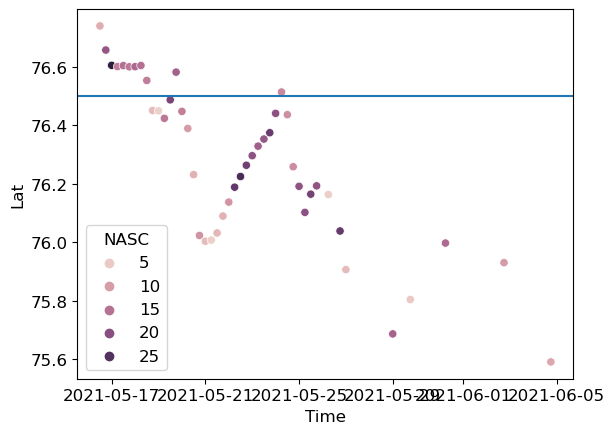

In [64]:
Isk21_daily =Isk_21_df.set_index('Time').resample('6H').mean()

sns.scatterplot(data=Isk21_daily, x='Time',y='Lat', hue='NASC')
plt.axhline(y=76.5)
fig.autofmt_xdate()

In [65]:
Iskant_21

,Region_ID,Region_name,Region_class,Process_ID,Sv_mean,NASC,Sv_max,Sv_min,Sv_noise,NASC_noise,...,Region_top_altitude_min,Region_top_altitude_max,Region_top_altitude_mean,Center_of_mass,Inertia,Proportion_occupied,Equivalent_area,Aggregation_index,datetime,platform
0,1,Region 1,SSL Strong,3130,-68.562469,6.238345,-63.840536,-83.512349,-968.562276,0.0,...,54.9,55.2,55.100000,25.511711,0.132141,1.000000,5.403474,0.185066,2021-05-16 16:02:19.503,Sailbuoy Iskant 2021
0,1,Region 1,SSL Strong,3132,-66.891608,10.038391,-60.387043,-77.226496,-977.070516,0.0,...,69.0,69.3,69.175000,11.447124,0.188977,1.000000,4.817918,0.207559,2021-05-16 17:09:15.551,Sailbuoy Iskant 2021
0,1,Region 1,SSL Strong,3134,-69.724958,4.928842,-61.287751,-117.097148,-956.050520,0.0,...,13.4,14.4,14.015789,67.042569,0.562145,0.970874,8.290207,0.120624,2021-05-16 18:02:24.573,Sailbuoy Iskant 2021
1,2,Region 2,SSL Strong,3134,-67.722508,6.848569,-60.111709,-101.658742,-955.237620,0.0,...,10.3,11.0,10.550042,69.921752,0.053845,1.000000,2.363115,0.423170,2021-05-16 18:02:20.523,Sailbuoy Iskant 2021
2,3,Region 3,SSL Strong,3134,-70.537922,13.539014,-60.496950,-91.983867,-954.971370,0.0,...,9.3,12.6,10.982609,70.957263,2.370014,1.000000,76.254016,0.013114,2021-05-16 18:04:22.024,Sailbuoy Iskant 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,3,Region 3,SSL Strong,3728,-72.672993,4.242731,-65.909779,-90.922652,-957.810135,0.0,...,20.8,22.5,21.760000,59.004404,0.548411,1.000000,8.895879,0.112412,2021-05-29 03:11:22.989,Sailbuoy Iskant 2021
0,1,Region 1,SSL Strong,3760,-69.163766,5.173095,-62.709718,-87.827967,-969.038244,0.0,...,55.8,56.2,56.085714,24.432457,0.114923,1.000000,7.536919,0.132680,2021-05-29 19:02:35.708,Sailbuoy Iskant 2021
0,1,Region 1,SSL Strong,3808,-67.414136,15.943388,-59.985062,-87.187236,-986.163811,0.0,...,76.6,77.0,76.880000,4.325103,0.670813,1.000000,9.082184,0.110106,2021-05-31 10:02:09.373,Sailbuoy Iskant 2021
0,1,Region 1,SSL Strong,3820,-66.675681,10.091405,-58.181118,-106.438347,-978.649857,0.0,...,70.6,70.8,70.650000,9.770978,0.074854,1.000000,2.911193,0.343502,2021-06-02 23:06:42.718,Sailbuoy Iskant 2021


In [66]:
iskant_daily21 = Iskant_21.set_index('datetime').groupby('Region_class').resample('6H').mean()
nRegions = Iskant_21.set_index('datetime').groupby('Region_class').resample('6H').count()['Region_class']
nRegions = nRegions.reset_index('datetime')
iskant_daily21['nRegions']=nRegions['Region_class'][:].values
iskant_daily21 = iskant_daily21.reset_index()

Text(0.5, 0, 'Date')

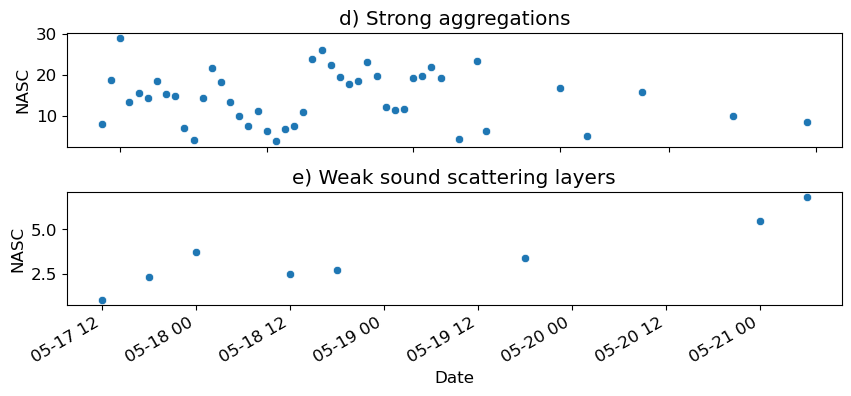

In [67]:
fig, ax = plt.subplots(2,1, figsize=(10,4))
axes = ax.flatten()
fig.subplots_adjust(hspace=.4, wspace=0.4)
#sns.lineplot(ax = axes[0], data=iskant_daily, x='datetime', y='Sv_mean',hue='Region_class')
strong_agg21 = iskant_daily21[iskant_daily21['Region_class']=='SSL Strong'].reset_index()
s = sns.scatterplot(ax = axes[0], data=strong_agg21, x='datetime', y='NASC', palette='Blues')
weak_layer21 = iskant_daily21[iskant_daily21['Region_class']=='SSL weak'].reset_index()
w = sns.scatterplot(ax = axes[1], data=weak_layer21, x='datetime', y='NASC', palette='Greens')

plt.gcf().autofmt_xdate()
#axes[0].set_xlim([dt.datetime(2022,5,19),dt.datetime(2022,7,24)])
#axes[1].set_xlim([dt.datetime(2022,5,19),dt.datetime(2022,7,24)])

axes[0].set_title('d) Strong aggregations')
axes[1].set_title('e) Weak sound scattering layers')
#axes[0].set_ylabel('Aggregation index')
#axes[1].set_ylabel('Aggregation index')
axes[1].set_xlabel('Date')
